<h1>Abstract</h1>

The lsst.sims.skybrightness package uses a several grids of template spectra downloaded from the [ESO SkyCalc](http://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC) to interpolate to arbitrary sky configurations. The ESO Sky Model includes components for the upper and lower atmosphere, airglow, zodical light, scattered starlight, and lunar light. In addition, we have added a twilight component based on fitting the sky brightness from the [Cerro Pachon All-Sky Camera Project](https://confluence.lsstcorp.org/display/SIM/Cerro+Pachon+All-Sky+Camera+Project).

Given a list of RA and Dec positions, a modified Julian date, and optionally a location (default is LSST's location), the skybrightness code will calculate the relevant parameters (airmasses, lunar phase and position, etc), and generate a spectrum by linearly interpolating from the grid of templates.  The resulting spectra run from 300 nm to 2 microns, with 0.1 nm steps.  The spectra can be convered to broadband magnitudes using the lsst.sims.photUtils package.

<h1>Quick Start</h1>

Here's a quick intro, see below for a more detailed stroll through the features.

In [1]:
%matplotlib inline

In [2]:
import lsst.sims.skybrightness as sb
import lsst.sims.photUtils.Bandpass as Bandpass
import os
import numpy as np
import matplotlib.pylab as plt

In [3]:
# Instatiate the sky model with default components turned on
sm = sb.SkyModel()

/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/interpComponents.py:76: RuntimeWarning: divide by zero encountered in log10
  self.logSpec = np.log10(self.spec['spectra'])


In [4]:
# Set the model to certain ra(s),dec(s), and mjd
sm.setRaDecMjd([30,35],[-10,-50],49353.177645, degrees=True)

In [5]:
# Calculate the spectra
sm.computeSpec()

/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/interpComponents.py:234: RuntimeWarning: invalid value encountered in multiply
  results[inRange] += amW[:,np.newaxis]*sfW[:,np.newaxis]*values[amIndex*self.nSolarFlux+sfIndex ]
/Users/yoachim/lsst/DarwinX86/healpy/1.8.1+6/lib/python/healpy-1.8.1-py2.7-macosx-10.5-x86_64.egg/healpy/pixelfunc.py:1045: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if phi == None:
/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/interpComponents.py:507: RuntimeWarning: invalid value encountered in multiply
  result += weight[:,np.newaxis]*values[mssid*nhpid*nMA+maid*nhpid+hpid]


/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


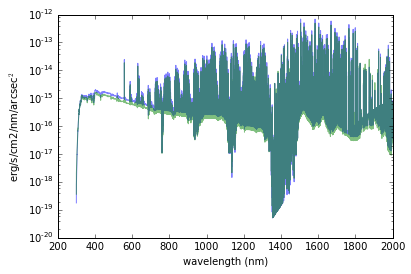

In [6]:
#plot the results
plt.semilogy(sm.wave, sm.spec[0], alpha=0.5)
plt.semilogy(sm.wave, sm.spec[1], alpha=0.5)
plt.xlabel('wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')

In [7]:
# Read in an LSST r filter and compute the surface brightnesses
throughPath = os.getenv('LSST_THROUGHPUTS_BASELINE')
bp = np.loadtxt(os.path.join(throughPath, 'filter_r.dat'),dtype=zip(['wave','trans'],[float]*2 ))
lsst_r = Bandpass()
lsst_r.setBandpass(bp['wave'], bp['trans'])

mags = sm.computeMags(bandpass=lsst_r)
print mags

[ 18.89364851  19.19396819]


In [8]:
# Just interpolate the magnitudes directly
sm = sb.SkyModel(mags=True)
sm.setRaDecMjd([30,35],[-10,-50],49353.177645, degrees=True)
sm.computeSpec()
print sm.computeMags()


[[ 19.68475563  18.85629542  18.89360895  18.85680768  18.37205923
   17.31174653]
 [ 19.83700851  19.11661217  19.19394103  19.18103703  18.71149621
   17.65264821]]


<h1>More Details</h1>

Stepping though the different components present in the sky model


In [9]:
import healpy as hp
from lsst.sims.skybrightness.utils import robustRMS, ut2Mjd, mjd2ut
from lsst.sims.maf.utils.telescopeInfo import TelescopeInfo
from lsst.sims.utils import calcLmstLast

In [10]:
# Load up the LSST filters for later
throughPath = os.getenv('LSST_THROUGHPUTS_BASELINE')
keys = ['u','g','r','i','z','y']
filters = {}
for filtername in keys:
    bp = np.loadtxt(os.path.join(throughPath, 'filter_'+filtername+'.dat'),
                    dtype=zip(['wave','trans'],[float]*2 ))
    tempB = Bandpass()
    tempB.setBandpass(bp['wave'],bp['trans'])
    filters[filtername] = tempB

In [11]:
# Set up a grid of RA,Dec points to compute the sky model on
nside = 16
hpmap = np.zeros(hp.nside2npix(nside))
lat, ra = hp.pix2ang(nside, np.arange(hpmap.size))
dec = np.pi/2-lat

In [12]:
# Instatiate the sky model, setting some extra components to true so that everything loads.
sm = sb.SkyModel(lowerAtm=True, upperAtm=True,airglow=True, scatteredStar=True)
sm.setRaDecMjd(ra,dec,49353.177645)

Adding component multiple times to the final output spectra.
Adding component multiple times to the final output spectra.
Adding component multiple times to the final output spectra.


We can check the where the model thinks the sun and moon are:

In [13]:
print sm.sunAlt, sm.moonAlt, sm.airmass

-36:13:54.5 28:20:40.1 [-2.10967604 -2.12820356 -1.87945844 ...,  1.8649941   2.10967604
  2.12820356]


In [14]:
compList = [ 'scatteredStar', 'lowerAtm', 'upperAtm', 'airglow', 'mergedSpec','twilight', 'zodiacal', 'moon']

We can now step though each component and see how it behaves.  First up, the scattered star light

In [15]:
# Turn off all the components
for comp in compList: setattr(sm, comp, False)
# Turn on the scattered starlight
sm.scatteredStar = True
# Compute the spectra
sm.computeSpec()

/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/interpComponents.py:119: RuntimeWarning: divide by zero encountered in divide
  w1 = (self.dimDict['airmass'][right] - interpPoints['airmass'][order])/fullRange
/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/interpComponents.py:120: RuntimeWarning: divide by zero encountered in divide
  w2 = (interpPoints['airmass'][order] - self.dimDict['airmass'][left])/fullRange


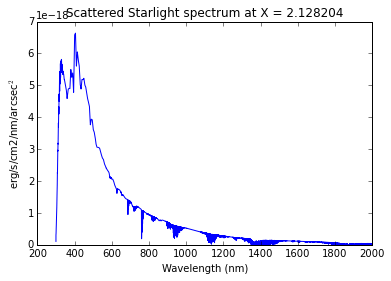

In [16]:
# Plot an example spectra
plt.plot(sm.wave, sm.spec[-1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.title('Scattered Starlight spectrum at X = %f' % sm.airmass[-1])

<h3>Properties of the spectra</h3>

In [17]:
print 'min wavelength = %.1f nm, max wavelength = %.1f nm' % (np.min(sm.wave), np.max(sm.wave))
print 'wavelength step size = %.2f nm' % (sm.wave[1]-sm.wave[0])
print 'number of points in spectrum = %i' % (sm.wave.size)

min wavelength = 300.0 nm, max wavelength = 2000.0 nm
wavelength step size = 0.10 nm
number of points in spectrum = 17001


In [18]:
mags = sm.computeMags(bandpass=filters['r'])
print 'LSST r-filter surface brightness = %f ' % mags[-1]

LSST r-filter surface brightness = 25.437652 


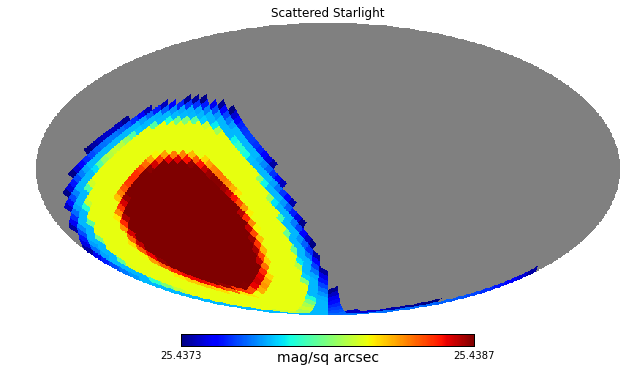

In [19]:
# Mask any pixels that failed to compute a mag
mags[np.where(mags < 0)] = hp.UNSEEN
hp.mollview(mags, unit='mag/sq arcsec', title='Scattered Starlight')

In [20]:
# We can rotate the projection to have zenith at the center, just rotating by the sideal time and observatory latitude
lmst,last = calcLmstLast(sm.mjd, sm.Observatory.lon)

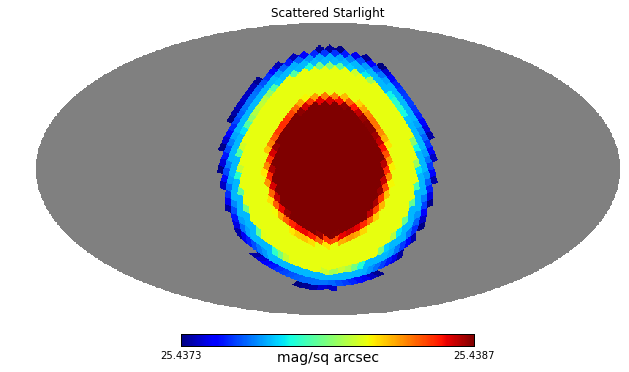

In [21]:
hp.mollview(mags, unit='mag/sq arcsec', title='Scattered Starlight',rot=(lmst*15, np.degrees(sm.Observatory.lat)))

Next up, let's look at the lower atmosphere

In [22]:
# Turn off all the components
for comp in compList: setattr(sm, comp, False)
# Turn on the one we want
sm.lowerAtm = True
component = 'Lower Atmosphere'

In [23]:
# Compute the spectra and mags
sm.computeSpec()
mags = sm.computeMags(bandpass=filters['r'])
mags[np.where(mags < 0)] = hp.UNSEEN

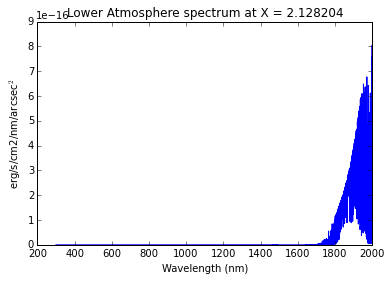

In [24]:
# Plot an example spectra
plt.plot(sm.wave, sm.spec[-1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.title('%s spectrum at X = %f' % (component, sm.airmass[-1]))

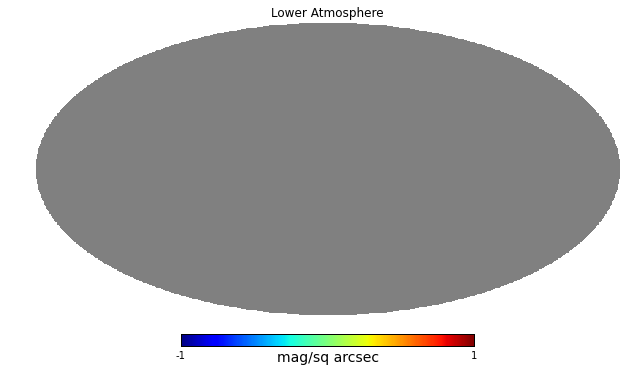

In [25]:
hp.mollview(mags, unit='mag/sq arcsec', title=component,rot=(lmst*15, np.degrees(sm.Observatory.lat)))

There's nothing there!  That's because the lower atmosphere is only emitting in the IR, so there's nothing in the r-filter.

Next up, the upper atmosphere.

In [26]:
# Turn off all the components
for comp in compList: setattr(sm, comp, False)
# Turn on the one we want
sm.upperAtm = True
component = 'Upper Atmosphere'

In [27]:
# Compute the spectra and mags
sm.computeSpec()
mags = sm.computeMags(bandpass=filters['r'])
mags[np.where(mags < 0)] = hp.UNSEEN

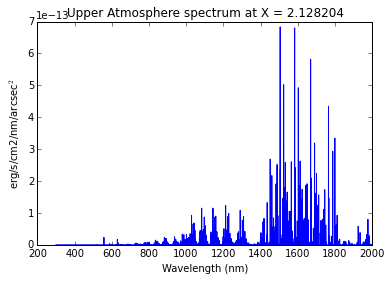

In [28]:
# Plot an example spectra
plt.plot(sm.wave, sm.spec[-1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.title('%s spectrum at X = %f' % (component, sm.airmass[-1]))

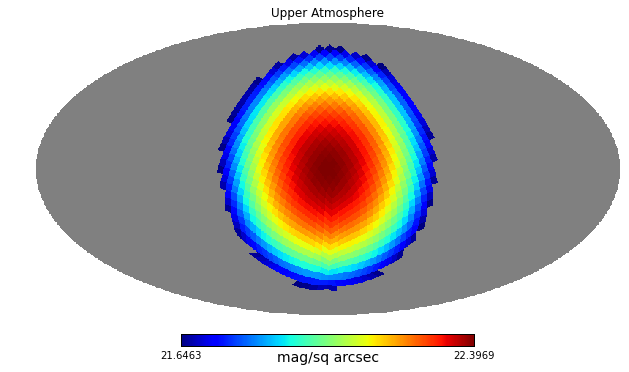

In [29]:
hp.mollview(mags, unit='mag/sq arcsec', title=component,rot=(lmst*15, np.degrees(sm.Observatory.lat)))

Note that all the above components are only vary with airmass, so they have been combined into the component mergedSpec so only one interpolation needs to be performed rather than 3 seperate interpolations.  

The above models are all interpolated from an airmass grid that runs from 1 to 2 in 0.1 steps, and then a final model at airmass 2.5.

Now for airglow. The airglow is computed at the same airmass values as the 1-D components, and then again at different levels of solar activity, ranging from 50-310 sfu with steps of 20 sfu.  

In [30]:
# Turn off all the components
for comp in compList: setattr(sm, comp, False)
# Turn on the one we want
sm.airglow = True
component = 'Airglow'

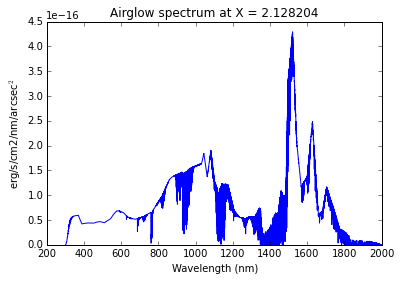

In [31]:
# Compute the spectra and mags
sm.computeSpec()
mags = sm.computeMags(bandpass=filters['r'])
mags[np.where(mags < 0)] = hp.UNSEEN
# Plot an example spectra
plt.plot(sm.wave, sm.spec[-1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.title('%s spectrum at X = %f' % (component, sm.airmass[-1]))

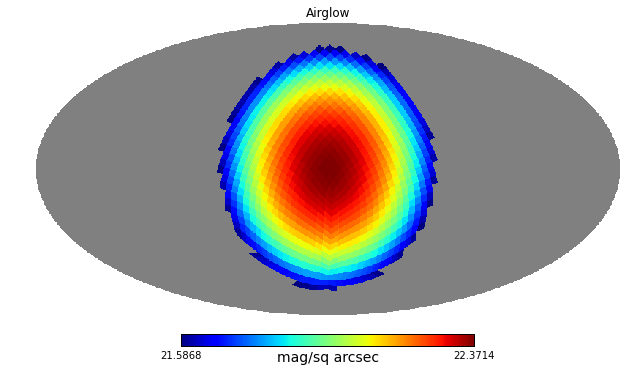

In [32]:
hp.mollview(mags, unit='mag/sq arcsec', title=component,rot=(lmst*15, np.degrees(sm.Observatory.lat)))

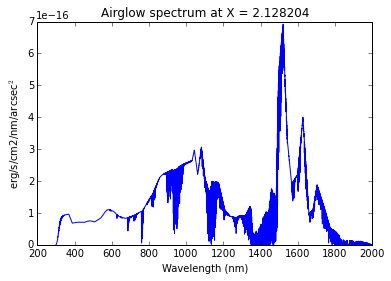

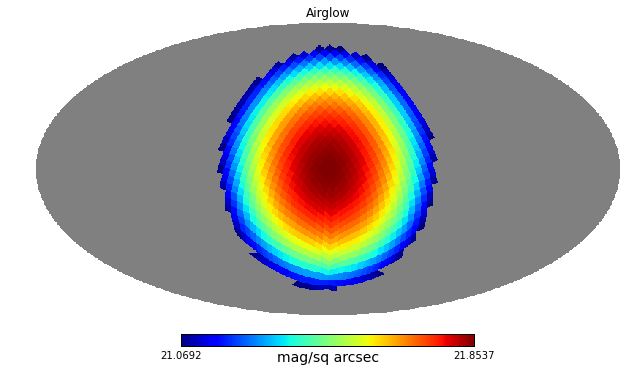

In [33]:
# Turn up the solar flux from the default 130 to 230.
sm.setRaDecMjd(sm.ra,sm.dec,sm.mjd, solarFlux=230.)
# Compute the spectra and mags
sm.computeSpec()
mags = sm.computeMags(bandpass=filters['r'])
mags[np.where(mags < 0)] = hp.UNSEEN
# Plot an example spectra
plt.plot(sm.wave, sm.spec[-1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.title('%s spectrum at X = %f' % (component, sm.airmass[-1]))

hp.mollview(mags, unit='mag/sq arcsec', title=component,rot=(lmst*15, np.degrees(sm.Observatory.lat)))

So we see that cranking up the solarFlux makes the airglow brighter.

Next up, the zodiacal light.  This is sunlight scattered off solar system dust.  It varies as a function of ecliptic latitude, ecliptic longitude (from the sun, e.g., ecliptic longitude - sun's longitude), and airmass.

In [34]:
sm = sb.SkyModel(lowerAtm=True, upperAtm=True,airglow=True, scatteredStar=True)
sm.setRaDecMjd(ra,dec,49353.177645)
# Turn off all the components
for comp in compList: setattr(sm, comp, False)
# Turn on the one we want
sm.zodiacal = True
component = 'Zodiacal'

Adding component multiple times to the final output spectra.
Adding component multiple times to the final output spectra.
Adding component multiple times to the final output spectra.


/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/interpComponents.py:567: RuntimeWarning: invalid value encountered in multiply
  result += weight[:,np.newaxis]*values[amid*nhpid+hpid]


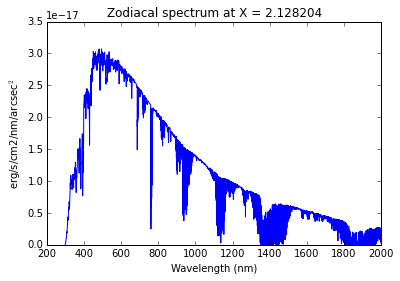

In [35]:
# Compute the spectra and mags
sm.computeSpec()
mags = sm.computeMags(bandpass=filters['r'])
mags[np.where(mags < 0)] = hp.UNSEEN
# Plot an example spectra
plt.plot(sm.wave, sm.spec[-1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.title('%s spectrum at X = %f' % (component, sm.airmass[-1]))

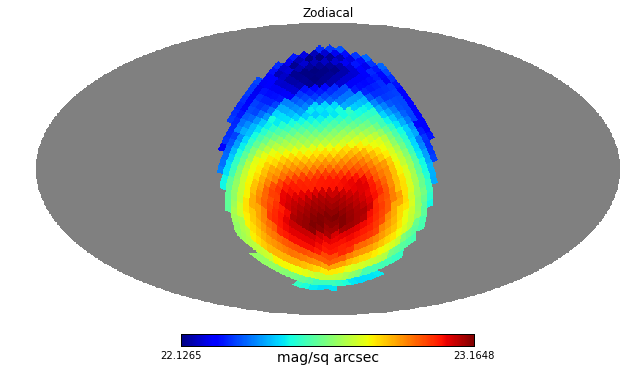

In [36]:
hp.mollview(mags, unit='mag/sq arcsec', title=component,rot=(lmst*15, np.degrees(sm.Observatory.lat)))

Note that for this particular mjd, the ecliptic is in the north, and that's where we see the most zodiacal light.

Next up, the lunar scattered ligth component.  The lunar spectra is computed on a grid of lunar illumination (0-100%), lunar altitude (0-90 degrees), target airmass, and target's azimuthal distance to the moon (0-180 degrees).

In [37]:
# Turn off all the components
for comp in compList: setattr(sm, comp, False)
# Turn on the one we want
sm.moon = True
component = 'Lunar'

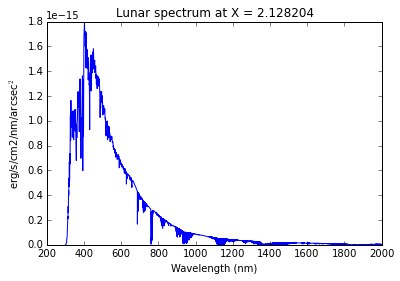

In [38]:
# Compute the spectra and mags
sm.computeSpec()
mags = sm.computeMags(bandpass=filters['r'])
mags[np.where(mags < 0)] = hp.UNSEEN
# Plot an example spectra
plt.plot(sm.wave, sm.spec[-1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.title('%s spectrum at X = %f' % (component, sm.airmass[-1]))

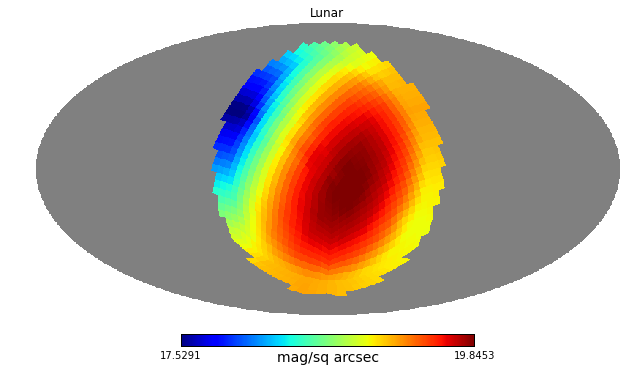

In [39]:
hp.mollview(mags, unit='mag/sq arcsec', title=component,rot=(lmst*15, np.degrees(sm.Observatory.lat)))

Finally, the twilight component is assumed to be a modified solar spectrum.  We fit the exponential decay of the twilight in multiple filters.  In each filter, the twilight flux in modeled as:

$f_{base} = f_0\rm{e}^{A\alpha} \rm{e}^{B(X-1)}$

where $\alpha$ is the altitude of the sun and $X$ is the airmass, and $f_0$ is the zenith flux when the sun is at altitude=0.  The final twilight function is then given by:

$f_{twi}(X > 1.1, \theta < \pi/2) = f_{base}\rm{e}^{C\cos{\theta}(X-1)}$

else

$f_{twi} = f_{base}$

where $\theta$ is the azimuthal distance to the sun.  We fit the $A$,$B$, and $C$ terms in three filters using the Cannon all-sky camera.  By default, the twilight component is only calculated for sun altitudes between -11 degrees and -20 degrees and for airmasses less than 2.5.  This corresponds to the limits of the data that the functions were fit to, although the limits can be expended and the fitted models are used to extrapolate the sky brightnesses.

In [40]:
# Turn off all the components
for comp in compList: setattr(sm, comp, False)
# Turn on the one we want
sm.twilight = True
component = 'Twilight'

# reset the mjd to be when the twilight component is still present
sm.setRaDecMjd(ra,dec,49353.177645-.14)
np.degrees(sm.sunAlt)
lmst,last = calcLmstLast(sm.mjd, sm.Observatory.lon)


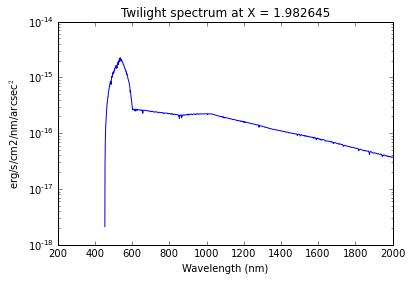

In [41]:
# Compute the spectra and mags
sm.computeSpec()
mags = sm.computeMags(bandpass=filters['r'])
mags[np.where(mags < 0)] = hp.UNSEEN
# Plot an example spectra
plt.semilogy(sm.wave, sm.spec[-1] )
plt.xlabel('Wavelength (nm)')
plt.ylabel('erg/s/cm2/nm/arcsec$^2$')
plt.title('%s spectrum at X = %f' % (component, sm.airmass[-1]))

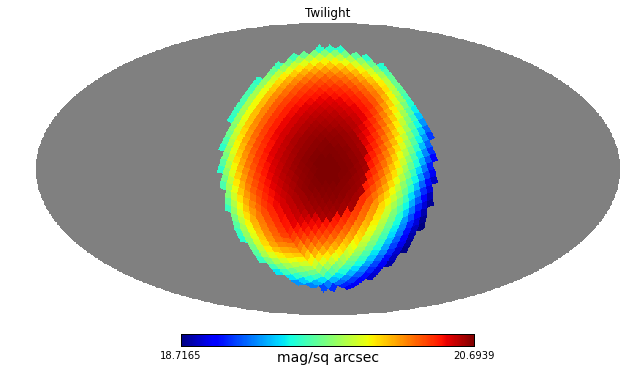

In [42]:
hp.mollview(mags, unit='mag/sq arcsec', title=component,rot=(lmst*15, np.degrees(sm.Observatory.lat)))

In [43]:
print sm.sunAlt

-12:56:23.3


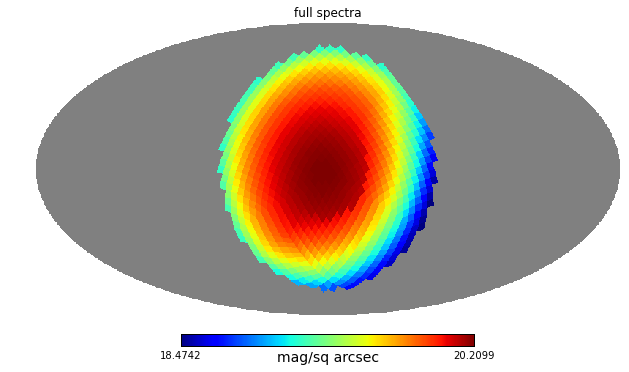

In [44]:
# Compare specta interpolation vs magnitude interpolation
sm = sb.SkyModel()
sm.setRaDecMjd(ra,dec,49353.177645-.14)
sm.computeSpec()
mags = sm.computeMags(bandpass=filters['r'])
mags[np.where(mags < 0)] = hp.UNSEEN
hp.mollview(mags, unit='mag/sq arcsec', title='full spectra',rot=(lmst*15, np.degrees(sm.Observatory.lat)))

/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/skyModel.py:247: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*np.log10(self.spec)+np.log10(3631.)
/Users/yoachim/gitRepos/sims_skybrightness/python/lsst/sims/skybrightness/skyModel.py:247: RuntimeWarning: invalid value encountered in log10
  mags = -2.5*np.log10(self.spec)+np.log10(3631.)
/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in less
/Users/yoachim/lsst/DarwinX86/healpy/1.8.1+6/lib/python/healpy-1.8.1-py2.7-macosx-10.5-x86_64.egg/healpy/pixelfunc.py:252: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/numpy/ma/core.py:2200: RuntimeWarning: invalid value encountered in less_equal
  condition = umath.less_equal(mabs(xnew - value), atol + rto

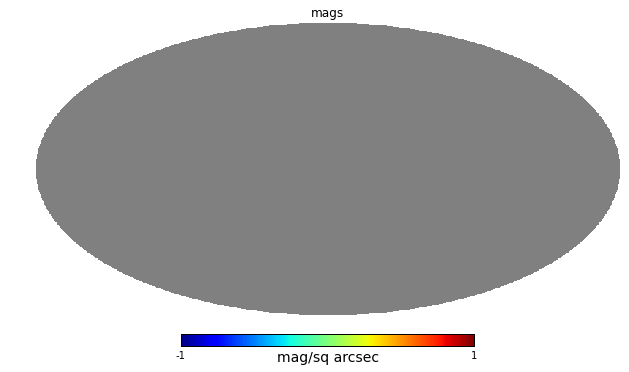

In [45]:
# Compare specta interpolation vs magnitude interpolation
sm = sb.SkyModel(mags=True)
sm.setRaDecMjd(ra,dec,49353.177645-.14)
sm.computeSpec()
mags = sm.computeMags()
mags[np.where(mags < 0)] = hp.UNSEEN
mags[np.isinf(mags)] = hp.UNSEEN
hp.mollview(mags[:,3], unit='mag/sq arcsec', title='mags',rot=(lmst*15, np.degrees(sm.Observatory.lat)))

In [46]:
mags

array([[ -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30,
         -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30],
       [ -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30,
         -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30],
       [ -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30,
         -1.63750000e+30,  -1.63750000e+30,  -1.63750000e+30],
       ..., 
       [             nan,   1.98303908e+01,              nan,
                     nan,   1.83773591e+01,   1.72561933e+01],
       [             nan,   1.96657504e+01,              nan,
                     nan,   1.82620719e+01,   1.71612593e+01],
       [             nan,   1.97668692e+01,              nan,
                     nan,   1.83512369e+01,   1.72451499e+01]])